In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
LOCATION = '../input/harvard-atlas-schizophrenia/'

In [3]:
participants = pd.read_csv(LOCATION + 'participants.csv')
control = participants[participants['diagnosis'] == 'Control']['id'].to_list()
schizophrenic = participants[participants['diagnosis'] != 'Control']['id'].to_list()

len(control), len(schizophrenic)

(206, 130)

In [4]:
tr = int(len(control) * 0.8)
va = tr + int(len(control) * 0.1)

train_list = control[:tr]
valid_list = control[tr:va]
test_list = control[va:]

tr = int(len(schizophrenic) * 0.8)
va = tr + int(len(schizophrenic) * 0.1)

train_list = train_list + schizophrenic[:tr]
valid_list = valid_list + schizophrenic[tr:va]
test_list = test_list + schizophrenic[va:]

random.shuffle(train_list)
random.shuffle(test_list)
random.shuffle(valid_list)

len(train_list), len(valid_list), len(test_list)

(268, 33, 35)

In [5]:
train_x, train_y = np.empty((0, 9216)), np.empty(0, int)
test_x, test_y = np.empty((0, 9216)), np.empty(0, int)
valid_x, valid_y = np.empty((0, 9216)), np.empty(0, int)

In [6]:
for train in train_list:
    diagnosis = participants[participants['id'] == train].iloc[0].diagnosis
    path = LOCATION + 'connectome/' + diagnosis + '/sub-'+train+'.npz'
        
    x = np.load(path)['arr_0'].reshape(-1)
    y = 0 if diagnosis == 'Control' else 1

    train_x = np.append(train_x, [x], axis=0)
    train_y = np.append(train_y, [y], axis=0)
    
train_x.shape, train_y.shape

((268, 9216), (268,))

In [7]:
for valid in valid_list:
    diagnosis = participants[participants['id'] == valid].iloc[0].diagnosis
    path = LOCATION + 'connectome/' + diagnosis + '/sub-'+valid+'.npz'
        
    x = np.load(path)['arr_0'].reshape(-1)
    y = 0 if diagnosis == 'Control' else 1

    valid_x = np.append(valid_x, [x], axis=0)
    valid_y = np.append(valid_y, [y], axis=0)
    
valid_x.shape, valid_y.shape

((33, 9216), (33,))

In [8]:
for test in test_list:
    diagnosis = participants[participants['id'] == test].iloc[0].diagnosis
    path = LOCATION + 'connectome/' + diagnosis + '/sub-'+test+'.npz'
        
    x = np.load(path)['arr_0'].reshape(-1)
    y = 0 if diagnosis == 'Control' else 1

    test_x = np.append(test_x, [x], axis=0)
    test_y = np.append(test_y, [y], axis=0)
    
test_x.shape, test_y.shape

((35, 9216), (35,))

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, losses
from tensorflow.keras.layers import Dense, Dropout, Activation, InputLayer

In [10]:
model = models.Sequential()

model.add(InputLayer(input_shape=(9216,)))
model.add(Dense(8192, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-04-06 15:37:21.022903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:37:21.037870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:37:21.038613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:37:21.040068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              75505664  
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2

In [11]:
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_loader = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

batch_size = 32
train_dataset = (train_loader.shuffle(len(train_x))
                 .batch(batch_size))

validation_dataset = (validation_loader.shuffle(len(valid_x))
                      .batch(batch_size))

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.01),
              metrics=["acc"])


checkpoint_cb = keras.callbacks.ModelCheckpoint("connectome_classification.h5",
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [13]:
%%time

epochs = 50
model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs=epochs,
          shuffle=True,
          verbose=2,
          callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50


2022-04-06 15:37:23.106974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


9/9 - 1s - loss: 0.7212 - acc: 0.5000 - val_loss: 0.6363 - val_acc: 0.6061


2022-04-06 15:37:23.856438: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301989888 exceeds 10% of free system memory.
2022-04-06 15:37:24.418128: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.
2022-04-06 15:37:24.757080: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301989888 exceeds 10% of free system memory.
2022-04-06 15:37:25.114352: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


Epoch 2/50
9/9 - 0s - loss: 0.6765 - acc: 0.6119 - val_loss: 0.6319 - val_acc: 0.6061


2022-04-06 15:37:28.545274: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301989888 exceeds 10% of free system memory.


Epoch 3/50
9/9 - 0s - loss: 0.6828 - acc: 0.6082 - val_loss: 0.6343 - val_acc: 0.6061
Epoch 4/50
9/9 - 0s - loss: 0.6512 - acc: 0.6082 - val_loss: 0.6414 - val_acc: 0.6061
Epoch 5/50
9/9 - 0s - loss: 0.6536 - acc: 0.6045 - val_loss: 0.6382 - val_acc: 0.6061
Epoch 6/50
9/9 - 0s - loss: 0.6554 - acc: 0.6119 - val_loss: 0.6334 - val_acc: 0.6061
Epoch 7/50
9/9 - 0s - loss: 0.6602 - acc: 0.6082 - val_loss: 0.6304 - val_acc: 0.6061
Epoch 8/50
9/9 - 0s - loss: 0.6520 - acc: 0.6157 - val_loss: 0.6331 - val_acc: 0.6061
Epoch 9/50
9/9 - 0s - loss: 0.6545 - acc: 0.6194 - val_loss: 0.6348 - val_acc: 0.6061
Epoch 10/50
9/9 - 0s - loss: 0.6523 - acc: 0.6269 - val_loss: 0.6343 - val_acc: 0.6061
Epoch 11/50
9/9 - 0s - loss: 0.6491 - acc: 0.6194 - val_loss: 0.6300 - val_acc: 0.6061
Epoch 12/50
9/9 - 0s - loss: 0.6486 - acc: 0.6194 - val_loss: 0.6304 - val_acc: 0.6061
Epoch 13/50
9/9 - 0s - loss: 0.6434 - acc: 0.6381 - val_loss: 0.6357 - val_acc: 0.5758
Epoch 14/50
9/9 - 0s - loss: 0.6494 - acc: 0.6231 

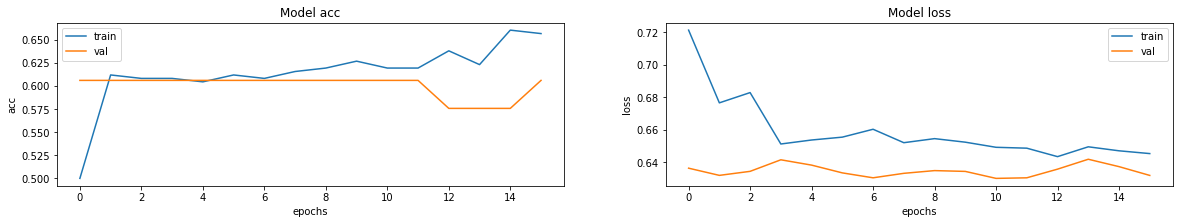

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [15]:
model.load_weights("connectome_classification.h5")

In [16]:
def get_probs(data):
    y = np.empty(0)
    
    for i in range(data.shape[0]):
        pred = model.predict(np.expand_dims(data[i], axis=0))
        y = np.append(y, pred[0], axis=0)
        
    return y

def get_predictions(data, threshold=0.5):
    y = get_probs(data)
    return np.where(y > threshold, 1, 0).astype(int)

In [17]:
from sklearn import metrics

pred_y = get_predictions(train_x, 0.4)
print("Accuracy:", metrics.accuracy_score(train_y, pred_y))
print("Confusion: \n", metrics.confusion_matrix(train_y, pred_y))
print(metrics.classification_report(train_y, pred_y))

Accuracy: 0.7201492537313433
Confusion: 
 [[135  29]
 [ 46  58]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       164
           1       0.67      0.56      0.61       104

    accuracy                           0.72       268
   macro avg       0.71      0.69      0.69       268
weighted avg       0.72      0.72      0.71       268



In [18]:
pred_y = get_predictions(valid_x, 0.4)
print("Accuracy:", metrics.accuracy_score(valid_y, pred_y))
print("Confusion:\n", metrics.confusion_matrix(valid_y, pred_y))
print(metrics.classification_report(valid_y, pred_y))

Accuracy: 0.696969696969697
Confusion:
 [[12  8]
 [ 2 11]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.58      0.85      0.69        13

    accuracy                           0.70        33
   macro avg       0.72      0.72      0.70        33
weighted avg       0.75      0.70      0.70        33



In [19]:
pred_y = get_predictions(test_x, 0.4)
print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Confusion:\n", metrics.confusion_matrix(test_y, pred_y))
print(metrics.classification_report(test_y, pred_y))

Accuracy: 0.7142857142857143
Confusion:
 [[17  5]
 [ 5  8]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.62      0.62      0.62        13

    accuracy                           0.71        35
   macro avg       0.69      0.69      0.69        35
weighted avg       0.71      0.71      0.71        35

